In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

 # linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/viacel/sample_submission.csv
/kaggle/input/viacel/train.csv
/kaggle/input/viacel/test.csv
/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv
/kaggle/input/health-insurance-cross-sell-prediction/train.csv
/kaggle/input/health-insurance-cross-sell-prediction/test.csv


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay ,classification_report
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import train_test_split

In [323]:
train = pd.read_csv("/kaggle/input/viacel/train.csv")
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,508077,Male,39,1,28.0,0,1-2 Year,Yes,33670.0,124.0,133,1
1,116379,Male,60,1,9.0,1,1-2 Year,Yes,32660.0,26.0,64,0
2,24159,Female,20,1,43.0,0,< 1 Year,No,2630.0,160.0,283,0
3,129481,Female,22,1,47.0,0,< 1 Year,Yes,32665.0,26.0,42,0
4,469280,Male,25,1,28.0,1,< 1 Year,No,21602.0,152.0,293,0


In [324]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [325]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244578 entries, 0 to 244577
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    244578 non-null  int64  
 1   Gender                244578 non-null  object 
 2   Age                   244578 non-null  int64  
 3   Driving_License       244578 non-null  int64  
 4   Region_Code           244578 non-null  float64
 5   Previously_Insured    244578 non-null  int64  
 6   Vehicle_Age           244578 non-null  object 
 7   Vehicle_Damage        244578 non-null  object 
 8   Annual_Premium        244578 non-null  float64
 9   Policy_Sales_Channel  244578 non-null  float64
 10  Vintage               244578 non-null  int64  
 11  Response              244578 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 22.4+ MB


In [326]:
train['Gender'] = train['Gender'].replace(to_replace = ['Male','Female'],value = [0,1])
train['Vehicle_Damage'] = train['Vehicle_Damage'].replace(to_replace = ['Yes','No'], value = [1,0])

In [327]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,508077,0,39,1,28.0,0,1-2 Year,1,33670.0,124.0,133,1
1,116379,0,60,1,9.0,1,1-2 Year,1,32660.0,26.0,64,0
2,24159,1,20,1,43.0,0,< 1 Year,0,2630.0,160.0,283,0
3,129481,1,22,1,47.0,0,< 1 Year,1,32665.0,26.0,42,0
4,469280,0,25,1,28.0,1,< 1 Year,0,21602.0,152.0,293,0


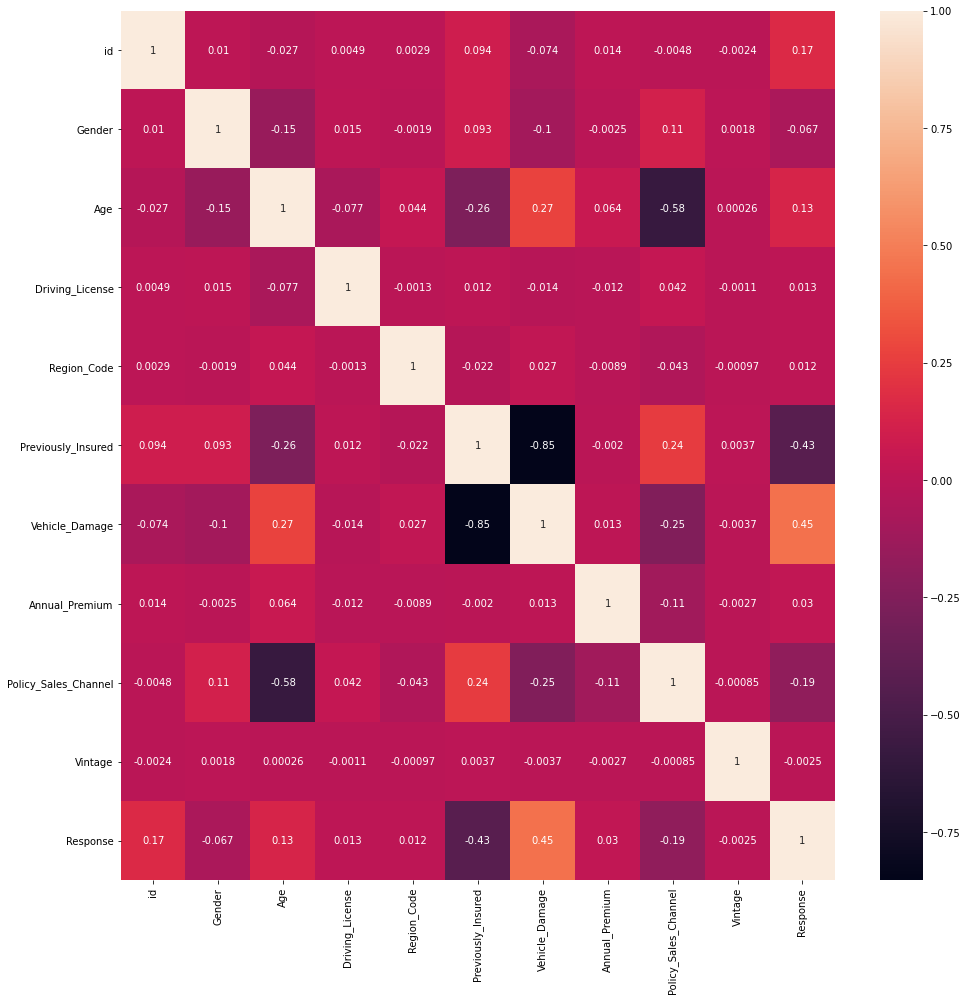

In [328]:
plt.figure(figsize = (16,16))
sns.heatmap(train.corr(),annot = True)
plt.show()

In [329]:
train['Vehicle_Age'] = train['Vehicle_Age'].replace(to_replace = ["1-2 Year","< 1 Year","> 2 Years"], value =[1,0,2] )

In [359]:
train0 = train.drop(['Region_Code','Vintage','Annual_Premium'], axis = 1)
#,'Annual_Premium'
#train0["Annual_Premium"]=np.log(train0["Annual_Premium"])
train0.head()

,id,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,508077,0,39,1,0,1,1,10.424363,124.0,1
1,116379,0,60,1,1,1,1,10.393906,26.0,0
2,24159,1,20,1,0,0,0,7.874739,160.0,0
3,129481,1,22,1,0,0,1,10.394059,26.0,0
4,469280,0,25,1,1,0,0,9.980541,152.0,0


In [360]:
x = train0.iloc[:,:-1].values
y = train0.iloc[:,-1].values
print(pd.DataFrame(x)) 

               0    1     2    3    4    5    6          7      8
0       508077.0  0.0  39.0  1.0  0.0  1.0  1.0  10.424363  124.0
1       116379.0  0.0  60.0  1.0  1.0  1.0  1.0  10.393906   26.0
2        24159.0  1.0  20.0  1.0  0.0  0.0  0.0   7.874739  160.0
3       129481.0  1.0  22.0  1.0  0.0  0.0  1.0  10.394059   26.0
4       469280.0  0.0  25.0  1.0  1.0  0.0  0.0   9.980541  152.0
...          ...  ...   ...  ...  ...  ...  ...        ...    ...
244573  218753.0  0.0  24.0  1.0  0.0  1.0  1.0  10.455446  122.0
244574  318355.0  1.0  20.0  1.0  0.0  0.0  1.0  10.428512  160.0
244575  300598.0  0.0  38.0  1.0  1.0  1.0  0.0  10.416880  122.0
244576    8591.0  1.0  33.0  1.0  1.0  1.0  0.0  10.763948  124.0
244577  174900.0  1.0  23.0  1.0  1.0  0.0  0.0  10.140495  152.0

[244578 rows x 9 columns]


In [361]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2,random_state=100,stratify=y)

In [362]:
XGB = XGBClassifier(n_estimators = 50, alpha =0.5, random_state = 0,scale_pos_weight=0.6,learning_rate=0.9,gamma=8,sample_type="uniform")
#LR = LogisticRegression()
#DTC = DecisionTreeClassifier()
#lgb=LGBMClassifier(random_state=30,n_estimators = 1500,learning_rate=0.008,reg_alpha=1,subsample=0.5,importance_type="gain")
#ada=AdaBoostClassifier(n_estimators=1000, learning_rate=2, algorithm='SAMME.R', random_state=35, base_estimator=None)
#svc=SVC()
#knn=KNeighborsClassifier()
#rf=RandomForestClassifier()
#lgb=LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=None, importance_type='split')

In [363]:
XGB.fit(x_train,y_train)
#LR.fit(x_train,y_train)
#DTC.fit(x_train,y_train)
#lgb.fit(x_train,y_train)
#ada.fit(x_train,y_train)
#svc.fit(x_train,y_train)
#knn.fit(x_train,y_train)
#rf.fit(x_train,y_train)

[21:55:44] WARNING: ../src/learner.cc:516: 
Parameters: { sample_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=8, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.9, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.5, reg_lambda=1, sample_type='uniform',
              scale_pos_weight=0.6, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [364]:
y_pred_XGB = XGB.predict(x_test)
#y_pred_LR = LR.predict(x_test)
#y_pred_DTC = DTC.predict(x_test)
#y_pred_lgp=lgb.predict(x_test)
#y_pred_ada=ada.predict(x_test)
#y_pred_svc=svc.predict(x_test)
#y_pred_knn=knn.predict(x_test)
#y_pred_rf=rf.predict(x_test)

In [365]:
print("xgb score : ",accuracy_score(y_pred_XGB,y_test))


xgb score :  0.8999713795077275


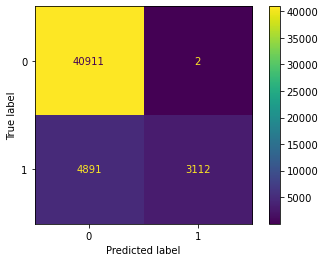

In [366]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_XGB)).plot()

In [367]:
print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     40913
           1       1.00      0.39      0.56      8003

    accuracy                           0.90     48916
   macro avg       0.95      0.69      0.75     48916
weighted avg       0.91      0.90      0.88     48916



[19:40:05] WARNING: ../src/learner.cc:516: 
Parameters: { sample_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:40:06] WARNING: ../src/learner.cc:516: 
Parameters: { sample_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:40:07] WARNING: ../src/learner.cc:516: 
Parameters: { sample_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:40:

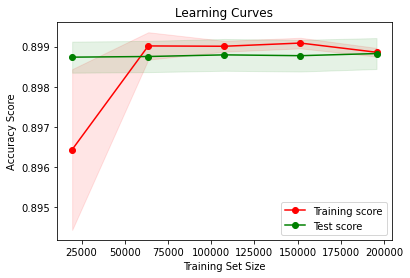

In [856]:
model =XGB

train_sizes, train_scores, test_scores = learning_curve(model, x, y,scoring='accuracy')


train_mean = np.mean(train_scores, axis=1)

train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)

test_std = np.std(test_scores, axis=1)

 

# Plot the learning curve

plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')

plt.plot(train_sizes, test_mean, 'o-', color='g', label='Test score')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')

plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

 

plt.xlabel('Training Set Size')

plt.ylabel('Accuracy Score')

plt.legend(loc='lower right')

plt.title('Learning Curves')

 

plt.show()

In [ ]:
"""
xg = accuracy_score(y_pred_XGB,y_test)
lr = accuracy_score(y_pred_LR,y_test)
dt = accuracy_score(y_pred_DTC,y_test)
lgb= accuracy_score(y_pred_lgp,y_test)
ada=accuracy_score(y_pred_ada,y_test)
svc=accuracy_score(y_pred_svc,y_test)
kn=accuracy_score(y_pred_knn,y_test)
rf=accuracy_score(y_pred_rf,y_test)

print("xgb :",xg,"\nlr :",lr,"\ndt :",dt,"\nlgb :",lgb,"\nada :",ada,"\nsvc :",svc,"\nkn :",kn,"\nrf :",rf)
"""

# test

In [368]:
test= pd.read_csv("/kaggle/input/viacel/test.csv")

test['Gender'] = test['Gender'].replace(to_replace = ['Male','Female'],value = [0,1])
test['Vehicle_Damage'] = test['Vehicle_Damage'].replace(to_replace = ['Yes','No'], value = [1,0])
test['Vehicle_Age'] = test['Vehicle_Age'].replace(to_replace = ["1-2 Year","< 1 Year","> 2 Years"], value =[1,0,2] )
test = test.drop(['Region_Code','Vintage','Annual_Premium'], axis = 1)
#test["Annual_Premium"]=np.log(test["Annual_Premium"])
#,'Annual_Premium'


test

,id,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,380337,0,30,1,1,0,0,11.017875,152.0
1,60095,0,40,1,0,1,1,7.874739,47.0
2,491957,1,40,1,0,1,1,10.543287,124.0
3,42481,0,51,1,0,1,1,10.346537,124.0
4,25992,0,24,1,1,0,0,9.932464,152.0
...,...,...,...,...,...,...,...,...,...
61140,287750,0,46,1,0,1,1,10.699372,26.0
61141,80519,1,25,1,1,0,0,10.531643,152.0
61142,314520,0,56,1,0,1,1,10.750600,26.0
61143,60089,0,23,1,1,0,0,10.760453,152.0


In [369]:
test0 = test.iloc[:,:].values 
test0

array([[3.80337000e+05, 0.00000000e+00, 3.00000000e+01, ...,
        0.00000000e+00, 1.10178748e+01, 1.52000000e+02],
       [6.00950000e+04, 0.00000000e+00, 4.00000000e+01, ...,
        1.00000000e+00, 7.87473913e+00, 4.70000000e+01],
       [4.91957000e+05, 1.00000000e+00, 4.00000000e+01, ...,
        1.00000000e+00, 1.05432867e+01, 1.24000000e+02],
       ...,
       [3.14520000e+05, 0.00000000e+00, 5.60000000e+01, ...,
        1.00000000e+00, 1.07505997e+01, 2.60000000e+01],
       [6.00890000e+04, 0.00000000e+00, 2.30000000e+01, ...,
        0.00000000e+00, 1.07604528e+01, 1.52000000e+02],
       [1.10405000e+05, 0.00000000e+00, 4.10000000e+01, ...,
        1.00000000e+00, 1.03363408e+01, 1.24000000e+02]])

In [371]:
y_pred = XGB.predict(test0)

In [372]:
submission = pd.DataFrame(y_pred,test['id'])

In [373]:
submission = submission.rename(columns = {0:'Response'})

In [374]:
submission.to_csv('./submission41.csv')